In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC
import seaborn as sns

In [281]:
data = pd.read_csv('../../data/card_transdata.csv')

continuous_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
data[continuous_features] = StandardScaler().fit_transform(data[continuous_features])


X = data.drop(columns=['fraud'])
# imputer = SimpleImputer(strategy='mean')
# X_im = imputer.fit_transform(X)
# X = pd.DataFrame(X_im, columns=X.columns, index= X.index)

y = data['fraud']

X, y = ADASYN().fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [282]:
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)
y_preds = logit_model.predict(X_test)

Original performance:

Accuracy: 0.9345130269637734
Precision: 0.9204298902407896
F1 score: 0.9354277345122223
Recall: 0.9509224362425694
Confusion Matrix: 
[[167916  14963]
 [  8933 173085]]


<Figure size 800x600 with 0 Axes>

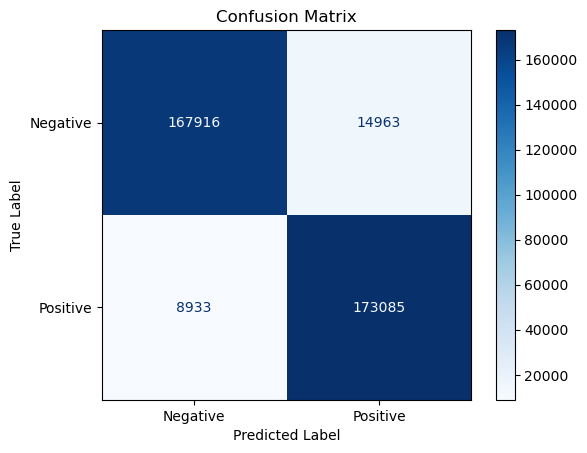

In [283]:
print(f'Accuracy: {logit_model.score(X_test, y_test)}')
print(f'Precision: {precision_score(y_test, y_preds)}')
print(f'F1 score: {f1_score(y_test, y_preds)}')
print(f'Recall: {recall_score(y_test, y_preds)}')
cm = confusion_matrix(y_test, y_preds)
print(f'Confusion Matrix: \n{cm}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                               display_labels=['Negative', 'Positive'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation='horizontal')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [250]:
dict(zip(logit_model.coef_.flatten(), X.columns))

{3.8989853792066334: 'price_online',
 8.34978575582875: 'chip_and_pin',
 21.36398216838321: 'total_distance'}

Now, let's engineer new features

In [284]:
X['price_online'] = X['ratio_to_median_purchase_price'] * X['online_order']
X['chip_and_pin'] = -(X['used_chip'] * X['used_pin_number'])
X['total_distance'] = np.log(X['distance_from_home']+10)  + np.log(X['distance_from_last_transaction']+10)

X = X.drop(columns=['ratio_to_median_purchase_price', 'online_order', 'used_chip', 'used_pin_number', 'distance_from_home', 'distance_from_last_transaction', 'repeat_retailer'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [285]:
logit_model.fit(X_train, y_train)
y_preds = logit_model.predict(X_test)

New performance:

Accuracy: 0.9153322718465758
Precision: 0.9127081660631284
F1 score: 0.9153805069774448
Recall: 0.9180685426716039
Confusion Matrix: 
[[166897  15982]
 [ 14913 167105]]


<Figure size 800x600 with 0 Axes>

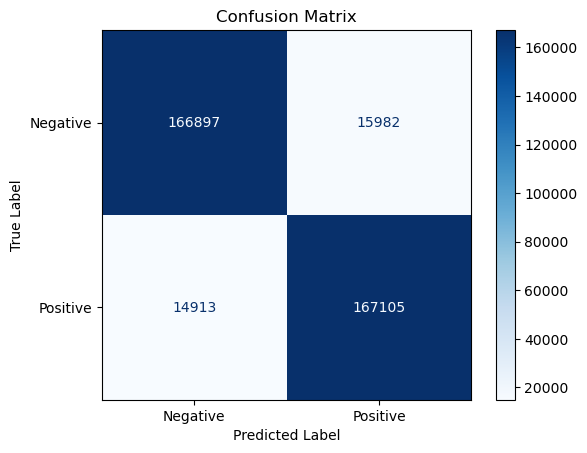

In [286]:
print(f'Accuracy: {logit_model.score(X_test, y_test)}')
print(f'Precision: {precision_score(y_test, y_preds)}')
print(f'F1 score: {f1_score(y_test, y_preds)}')
print(f'Recall: {recall_score(y_test, y_preds)}')
cm = confusion_matrix(y_test, y_preds)
print(f'Confusion Matrix: \n{cm}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                               display_labels=['Negative', 'Positive'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation='horizontal')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [108]:
dict(zip(logit_model.coef_.flatten(), X.columns))

{-0.8133154837481662: 'repeat_retailer',
 3.7798945024499564: 'price_online',
 -6.388928860126977: 'chip_and_pin',
 1.8215524185310086: 'total_distance'}

In [254]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
y_preds = decision_tree_model.predict(X_test)

print(f'Accuracy: {decision_tree_model.score(X_test, y_test)}')
print(f'Precision: {precision_score(y_test, y_preds)}')
print(f'F1 score: {f1_score(y_test, y_preds)}')
print(f'Recall: {recall_score(y_test, y_preds)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_preds)}')

Accuracy: 0.9463766487529358
Precision: 0.9499554063561176
F1 score: 0.9460275778748101
Recall: 0.9421320968255886
Confusion Matrix: 
[[173845   9034]
 [ 10533 171485]]


Experimenting  new features with XGBoost

In [255]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_preds = xgb_clf.predict(X_test)

In [256]:
print(f'Accuracy: {xgb_clf.score(X_test, y_test)}')
print(f'Precision: {precision_score(y_test, y_preds)}')
print(f"XGB F1 score: {f1_score(y_test, y_preds)}")
print(f'Recall: {recall_score(y_test, y_preds)}')
print(f"Conufsion matrix:\n {confusion_matrix(y_test, y_preds)}")

Accuracy: 0.9640884962057786
Precision: 0.9460788456256735
XGB F1 score: 0.9647125353440151
Recall: 0.9840949796174004
Conufsion matrix:
 [[172670  10209]
 [  2895 179123]]
